# Test notebook for Acceptance Test Campaign related to LSST Science Pipelines Release 19.0.0

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `r19-0-0`.

### Test case LVV-T40: Verify implementation of Generate WCS for Visit Images
Verify that Processed Visit Images produced by the AP and DRP pipelines include FITS WCS accurate to specified **astrometricAccuracy** over the bounds of the image.

### Test case LVV-T1240: Verify implementation of minimum astrometric standards per CCD
Verify that each CCD in a processed dataset had its astrometric solution determined by at least **astrometricMinStandards = 5** astrometric standards.

#### Discussion:
For this test we interpret the requirement to mean that the _absolute_ astrometry (as compared to an external reference source of "truth" such as Gaia DR2) should meet the specified accuracy. Thus the verification will be done by comparing to Gaia DR2 (note, however, that the HSC-RC2 data were astrometrically and photometrically calibrated to PanSTARRS-1).

In [211]:
# Confirm that the version of the Science Pipelines is v19_0_0:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-jcarlin-r19-0-0
lsst_distrib          19.0.0+2   	current v19_0_0 setup


In [212]:
import lsst.daf.persistence as dafPersist
import lsst.geom as geom

In [213]:
import os
import glob
import numpy as np
import pandas as pd
import random

import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [214]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 24})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 5})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

We will use HSC-RC2, as processed using `w_2019_46`, which is the pipelines version that was used to create `v19_0_0`.

In [215]:
# The output repo is tagged with the Jira ticket number "DM-22223":

rc2_repo = '/datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223-sfm'

In [216]:
# Initialize the butler repo:
butler = dafPersist.Butler(rc2_repo)

# Make a glob of the files in the repo, so we can parse this to get tract/patch IDs:
infiles = glob.glob(rc2_repo+'/*/*/corr/CORR*.fits')
# /datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223-sfm/01172/HSC-R/corr
print(len(infiles))

44496


### Make arrays of the tract, patch numbers by parsing the filenames

In [217]:
filt_array = []
ccd_array = []
visit_array = []
tract_array = []

# Each line of "infiles" looks like this (infile[0]):
# /datasets/hsc/repo/rerun/RC/w_2019_46/DM-22223-sfm/01172/HSC-R/corr/CORR-0030500-037.fits

# Split on the '/', then parse the resulting array. Here's the result of infiles[0].split('/'):

#['',
# 'datasets',
# 'hsc',
# 'repo',
# 'rerun',
# 'RC',
# 'w_2019_46',
# 'DM-22223-sfm',
# '01170',
# 'HSC-Z',
# 'corr',
# 'CORR-0023226-028.fits']

# So the tract number is third from the end, and patch is second from the end.

for ii in range(0, len(infiles)):
    parts = infiles[ii].split('/')
    # Only keep ones with filters starting with 'HSC' (ditch the narrow-band filters):
    if np.str.startswith(parts[-3], 'HSC'):
        tract_array.append(int(parts[-4]))
        filt_array.append(parts[-3])
        # Split the file name to extract the visit number:
        file_str = parts[-1]
        file_str2 = file_str.split('.fits')
        file_str3 = file_str2[0].split('-')
        visit_array.append(int(file_str3[-2]))
        ccd_array.append(int(file_str3[-1]))

print('Found %i images'%(len(ccd_array)))
        
# Assemble in pandas data frame    
data = {'tract': tract_array,
        'filter': filt_array,
        'ccd': ccd_array,
        'visit': visit_array}
df_filter_ccd_visit = pd.DataFrame(data=data)

Found 41612 images


In [218]:
#df_filter_ccd_visit

In [219]:
# Check the CCD numbers that are available:
print(df_filter_ccd_visit.ccd.unique())

[ 28  95  62  52  78  87  74  29 102  48  27   6  51  68  24  41  61  81
  58  72  88  42  66  63  77  93  60  40  64  67  83  33  71  85  11  21
  31  54 103  91  32  26  25  90  92  89  57  94  59   4  45  18  19  39
  16  76  17  30  35   7   2  82  14  37  22  79  70   3  97  38  80  96
  69  53  55  47  46   5  13  50  23  75   1  15  99 101  86  65  36  56
  84  49  98  43  20   0   8  44  73  12  10  34 100]


It would take a prohibitively long time to check every CCD from every visit, so we will randomly select a subset to test. For now, the test is using `astroquery` to match to Gaia, but implementing a more direct match to the Gaia database on lsst-dev would likely streamline the process.

In [220]:
haswcs_flags = []
num_calib_astrom = []
median_mag_astrom = []
datarefs = []
medianAstromOffsets = []
numGaiaMatches = []

# Select some visit/ccd combinations from these at random:
numvisits = 500 # 100 runs in a few min. 500 takes ~0.5 hr.
visit_sel = df_filter_ccd_visit.sample(numvisits)

for row, vis in visit_sel.iterrows():
    # print(vis)
    dataref = {'tract':vis['tract'], 'filter':vis['filter'], 'visit':vis['visit'], 'ccd':vis['ccd']}
    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.datasetExists('calexp', dataId = dataref):
        calexp = butler.get('calexp', dataId = dataref)
        haswcs_flags.append(butler.get('calexp', dataId = dataref).hasWcs())
#        haswcs_flags.append(butler.datasetExists('calexp_wcs', dataId = dataref))

        # Check how many objects were used to calibrate the astrometry:
        src = butler.get('src', dataId = dataref)
        astrom_selection = np.where(src['calib_astrometry_used'] == True)
        num_calib_astrom.append(np.size(astrom_selection))
        calexp_calib = butler.get('calexp_photoCalib', dataId=dataref)
        src_mag = calexp_calib.instFluxToMagnitude(src, 'base_PsfFlux')

        median_mag_astrom.append(np.median(src_mag[astrom_selection,0]))

        # Extract the WCS+calexp and match to Gaia:
        wcs = calexp.getWcs()
        center = wcs.pixelToSky(calexp.getX0()+calexp.getWidth()/2.0, calexp.getY0()+calexp.getHeight()/2.0)
        pscale = wcs.getPixelScale()
        width = calexp.getWidth()*pscale.asDegrees()
        height = calexp.getHeight()*pscale.asDegrees()
#        wcs = butler.get('calexp_wcs', dataId = dataref)
        cen = SkyCoord(center.getRa().asDegrees()*u.degree, center.getDec().asDegrees()*u.degree)
        width = u.Quantity(width, u.deg)
        height = u.Quantity(height, u.deg)

        # Start from XY, then use the WCS to convert to RA, Dec:
        xxx = src.getX()
        yyy = src.getY()
        radec = [wcs.pixelToSky(xxx[i], yyy[i]) for i in range(len(xxx))]
        radec_arr = np.array([(coo.getRa().asDegrees(), coo.getDec().asDegrees()) for coo in radec])

        gaia_mch = Gaia.query_object_async(coordinate=cen, width=width, height=height)
        # gaia_mch.pprint()
        sc_src = SkyCoord(radec_arr[:,0]*u.deg, radec_arr[:,1]*u.deg)
#        sc_src = SkyCoord(src['coord_ra']*u.rad, src['coord_dec']*u.rad)
        sc_gaia = SkyCoord(gaia_mch['ra'], gaia_mch['dec'])
        src_match = sc_src.match_to_catalog_sky(sc_gaia)
        sep_match = src_match[1]
        
        gaia_gmag = gaia_mch['phot_g_mean_mag']
        # gaia_bpmag = gaia_mch['phot_bp_mean_mag']
        # gaia_rpmag = gaia_mch['phot_rp_mean_mag']
        
        okmch = (sep_match.arcsec < 2.0)
        matchsep = sep_match[okmch]
        
        # Require the matches to have similar magnitudes:
        magdiff = src_mag[okmch][:,0]-gaia_gmag[src_match[0][okmch]]
        
        okmagdiff = (np.abs(magdiff - np.median(magdiff)) < 1.0)
        okmatchsep = matchsep[okmagdiff]
        
        medianOffset = np.median(np.array(okmatchsep.marcsec))
        medianAstromOffsets.append(medianOffset)
        numGaiaMatches.append(np.size(okmatchsep))

        # Save the datarefs for later:
        datarefs.append(dataref)


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/lsst/software/stack/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


In [221]:
# Convert the outputs of the previous cell to numpy arrays:
numGaiaMatches = np.array(numGaiaMatches)
medianAstromOffsets = np.array(medianAstromOffsets)
num_calib_astrom = np.array(num_calib_astrom)
median_mag_astrom = np.array(median_mag_astrom)

# Keep only the CCDs with at least one Gaia match:
okmch = np.where(numGaiaMatches >= 1)

nGaiaMatches = numGaiaMatches[okmch[0]]
medAstromOffsets = medianAstromOffsets[okmch[0]]
n_calib_astrom = num_calib_astrom[okmch[0]]
med_mag_astrom = median_mag_astrom[okmch[0]]

#### Did all of the CCDs use more than `astrometricMinStandards` = 5 standards?

In [222]:
# Calculate the fraction of fields that used > 5 standards for astrometric calibration:
wcsFlagsPercent = (np.size(np.where(haswcs_flags))/np.size(haswcs_flags))*100.0*u.percent
print('Percentage of fields with > astrometricMinStandards=5: ', wcsFlagsPercent,' -- ',wcsFlagsPercent == 100.0*u.percent)

Percentage of fields with > astrometricMinStandards=5:  100.0 %  --  True


#### Fraction of CCDs meeting the `astrometricAccuracy` threshold:

In [223]:
# Calculate the fraction of CCDs that meet the requirement:
astrometricAccuracy = 50.0 # 50 mas is the threshold in the requirement
astromMeetsThreshPercent = (np.size(np.where(medAstromOffsets < astrometricAccuracy))/np.size(medAstromOffsets))*100.0*u.percent
print('Percentage of fields meeting the threshold: ', astromMeetsThreshPercent,' -- ',astromMeetsThreshPercent == 100.0*u.percent)

Percentage of fields meeting the threshold:  81.89134808853119 %  --  False


### Discussion, figures:
For any random selection of CCDs on which we calculate this, a small fraction do not meet the threshold. This may have more to do with the matching to Gaia than the accuracy of the WCS. Let's explore...

#### Compare the median value of the astrometric residuals (vs. Gaia) to the number of Gaia sources matched:

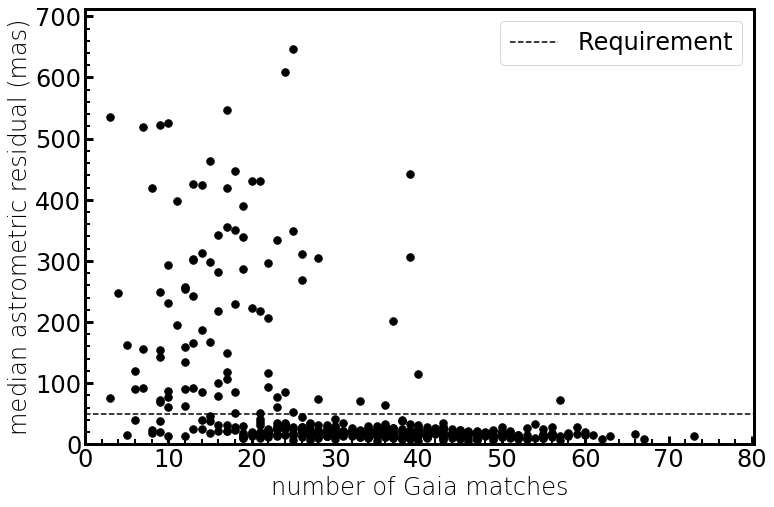

In [224]:
#print(medianAstromOffsets, numGaiaMatches)
plt.plot(nGaiaMatches, medAstromOffsets, 'k.', ms=15)
plt.xlabel('number of Gaia matches')
plt.ylabel('median astrometric residual (mas)')
plt.hlines(astrometricAccuracy, 0, 100, linestyle='dashed', label='Requirement')
plt.xlim(0,np.max(nGaiaMatches)*1.1)
plt.ylim(0,np.max(medAstromOffsets)*1.1)
plt.legend()
plt.minorticks_on()
plt.show()

Most of the objects with high residuals are those that have few Gaia matches. Do they also have few astrometric calibrators?

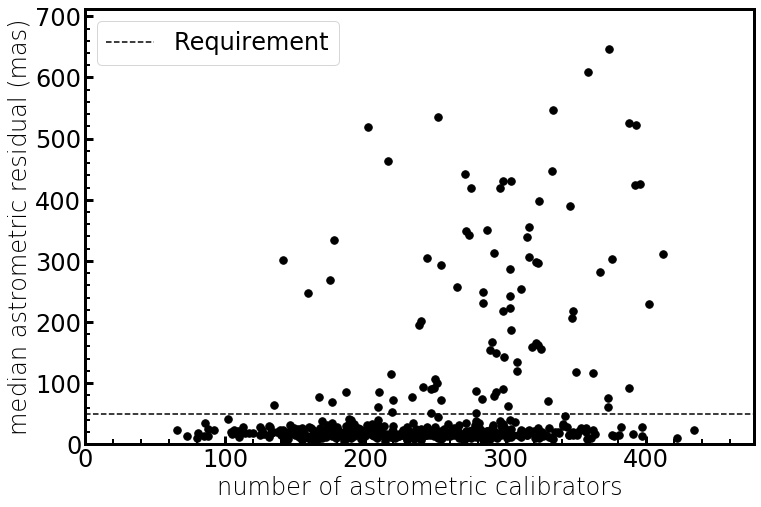

In [225]:
plt.plot(n_calib_astrom, medAstromOffsets, 'k.', ms=15)
plt.xlabel('number of astrometric calibrators')
plt.ylabel('median astrometric residual (mas)')
plt.hlines(astrometricAccuracy, 0, 1000, linestyle='dashed', label='Requirement')
plt.xlim(0,np.max(n_calib_astrom)*1.1)
plt.ylim(0,np.max(medAstromOffsets)*1.1)
plt.legend()
plt.minorticks_on()
plt.show()

In fact, it seems that many of the fields with large residuals have large numbers of calibrators (and _all_ have > 50).

Furthermore, there seem to be too few Gaia matches per CCD to be able to split them into smaller spatial regions. 

#### What is the median magnitude of sources that contributed to the astrometric solution?

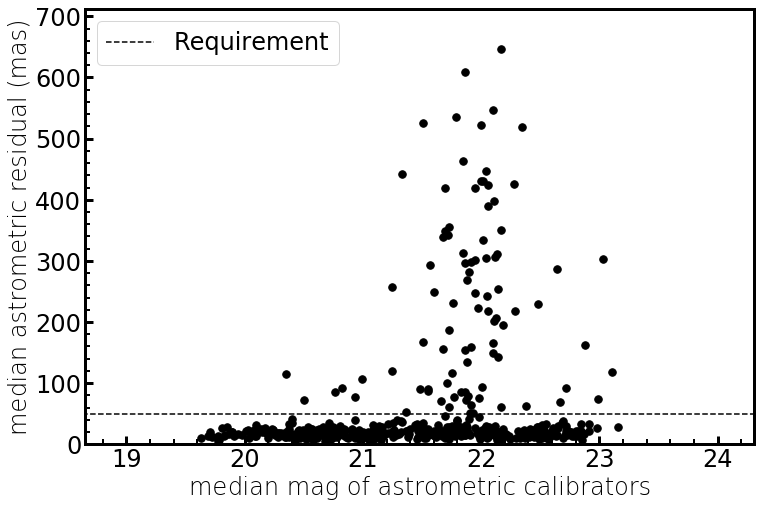

In [226]:
# Just to try to understand the previous two plots, check the median mag of astrometric calibrators:
plt.plot(med_mag_astrom, medAstromOffsets, 'k.', ms=15)
plt.xlabel('median mag of astrometric calibrators')
plt.ylabel('median astrometric residual (mas)')
plt.hlines(astrometricAccuracy, 0, 1000, linestyle='dashed', label='Requirement')
plt.xlim(np.min(med_mag_astrom)*0.95,np.max(med_mag_astrom)*1.05)
plt.ylim(0,np.max(medAstromOffsets)*1.1)
plt.legend()
plt.minorticks_on()
plt.show()

It seems that the fields with large astrometric residuals when compared to Gaia were calibrated using faint stars. These may be deep exposures, so that many Gaia objects saturate, or some other similar effect. Because of this small fraction of fields, the test for LVV-T40 technically does not pass. Given that this may be due to a lack of Gaia reference catalog objects, and not due to a deficiency in DM algorithms, we consider the result of this test __"Pass With Deviations."__